# Lecture 4: Bayesian Analysis via MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats

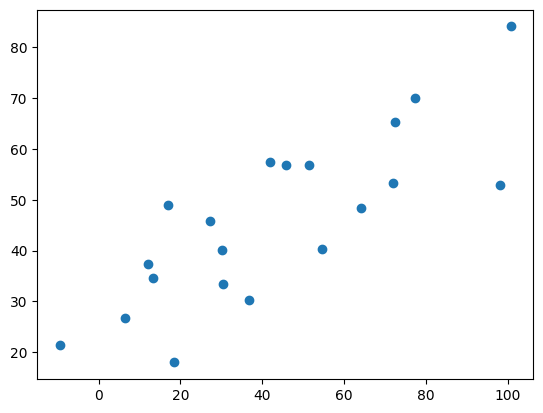

In [2]:
np.random.seed(42) 
theta_true = (25, 0.5) 
xdata = 100 * np.random.random(20) 
ydata = theta_true[0] + theta_true[1] * xdata 
 
# add scatter to points 
xdata = np.random.normal(xdata, 10) 
ydata = np.random.normal(ydata, 10) 

# plot data 
plt.scatter(xdata, ydata) 
plt.show()

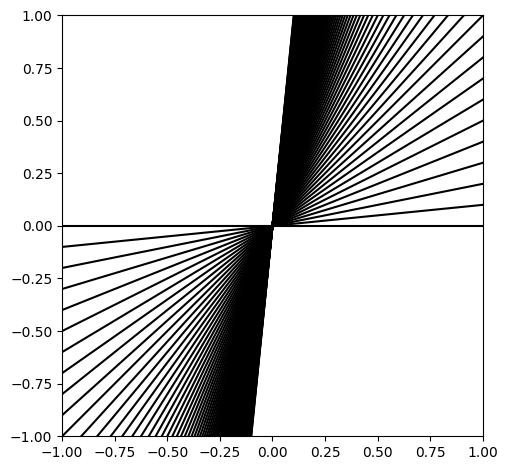

In [3]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal')) 
x = np.linspace(-1, 1) 
 
for slope in np.arange(0, 10, 0.1): 
    plt.plot(x, slope * x, '-k') 
 
ax.axis([-1, 1, -1, 1]); 
# Show the figure 
plt.tight_layout()

In [4]:
# Create some convenience routines for plotting 
 
def compute_sigma_level(trace1, trace2, nbins=20): 
    """From a set of traces, bin by number of standard deviations""" 
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16 
    logL = np.log(L) 
 
    shape = L.shape 
    L = L.ravel() 
 
    # obtain the indices to sort and unsort the flattened array 
    i_sort = np.argsort(L)[::-1] 
    i_unsort = np.argsort(i_sort) 
 
    L_cumsum = L[i_sort].cumsum() 
    L_cumsum /= L_cumsum[-1] 
     
    xbins = 0.5 * (xbins[1:] + xbins[:-1]) 
    ybins = 0.5 * (ybins[1:] + ybins[:-1]) 
 
    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs): 
    """Plot traces and contours""" 
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1]) 
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs) 
    if scatter: 
        ax.plot(trace[0], trace[1], ',k', alpha=0.1) 
    ax.set_xlabel(r'$\alpha$') 
    ax.set_ylabel(r'$\beta$') 
     
     
def plot_MCMC_model(ax, xdata, ydata, trace): 
    """Plot the linear model and 2sigma contours""" 
    ax.plot(xdata, ydata, 'ok') 
 
    alpha, beta = trace[:2] 
    xfit = np.linspace(-20, 120, 10) 
    yfit = alpha[:, None] + beta[:, None] * xfit 
    mu = yfit.mean(0) 
    sig = 2 * yfit.std(0) 
 
    ax.plot(xfit, mu, '-k') 
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray') 
 
    ax.set_xlabel('x') 
    ax.set_ylabel('y')

def plot_MCMC_results(xdata, ydata, trace, colors='k'): 
    """Plot both the trace and the model together""" 
    fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors) 
    plot_MCMC_model(ax[1], xdata, ydata, trace)

In [5]:
# Define our posterior using Python functions 
# for clarity, I've separated-out the prior and likelihood 
# but this is not necessary. Note that emcee requires log-posterior 
 
def log_prior(theta): 
    alpha, beta, sigma = theta 
    if sigma < 0: 
        return -np.inf  # log(0) 
    else: 
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma) 
 
def log_likelihood(theta, x, y): 
    alpha, beta, sigma = theta 
    y_model = alpha + beta * x 
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 
2 / sigma ** 2) 
 
def log_posterior(theta, x, y): 
    return log_prior(theta) + log_likelihood(theta, x, y)

In [6]:
ndim = 3  # number of parameters in the model 
nwalkers = 50  # number of MCMC walkers 
nburn = 1000  # "burn-in" period to let chains stabilize 
nsteps = 2000  # number of MCMC steps to take 
 
# set theta near the maximum likelihood, with  
np.random.seed(0) 
starting_guesses = np.random.random((nwalkers, ndim))

In [7]:
# Here's the function call where all the work happens: 
# we'll time it using IPython's %time magic 
 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
args=[xdata, ydata]) 
%time sampler.run_mcmc(starting_guesses, nsteps) 
print("done") 

CPU times: user 3.81 s, sys: 7.62 ms, total: 3.82 s
Wall time: 3.82 s
done


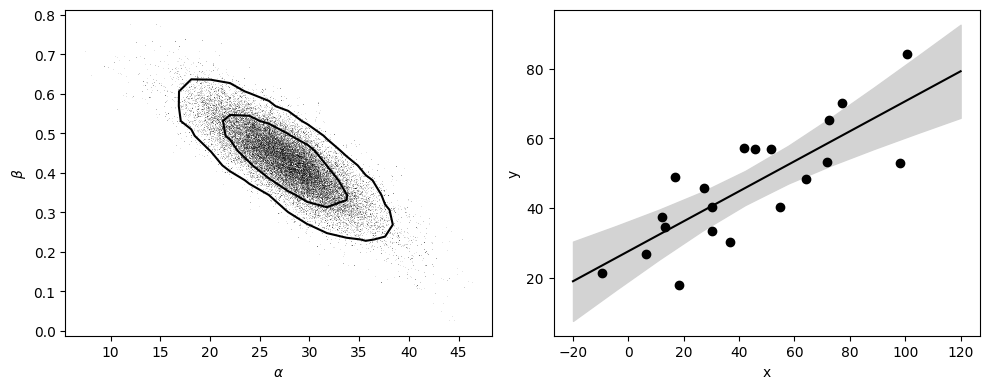

In [8]:
#  sampler.chain is of shape (nwalkers, nsteps, ndim) 
# we'll throw-out the burn-in points and reshape: 
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T 
plot_MCMC_results(xdata, ydata, emcee_trace) 
# Show the figure 
plt.tight_layout()